In [30]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt

In [31]:
df = pd.read_csv('../final_merged_output.csv')
df = df[df['Year'] <= 2022]
chicago = df[df['City'] == 'Chicago']
ny = df[df['City'] == 'New York']
phoenix = df[df['City'] == 'Phoenix']
la = df[df['City'] == 'Los Angeles']
houston = df[df['City'] == 'Houston']
chicago.tail()

,City,Year,Quarter,index_nsa,Median Household Income,Total Population,INDPRO,VIXCLS,CPI,Unemployment Rate,City GDP
127,Chicago,2021,4,214.65,66576.0,2696561.00,100.939133,19.318636,4.697859,4.400000,770533358.0
128,Chicago,2022,1,221.00,67528.5,2688686.75,101.911200,25.349844,8.002800,4.866667,845186849.0
129,Chicago,2022,2,234.20,68481.0,2680812.50,102.896900,27.322077,8.002800,4.633333,845186849.0
130,Chicago,2022,3,235.88,69433.5,2672938.25,103.251133,24.792727,8.002800,4.766667,845186849.0
131,Chicago,2022,4,232.43,70386.0,2665064.00,102.792200,24.945077,8.002800,4.166667,845186849.0


Mean Absolute Error (MAE): 4.9857
Root Mean Squared Error (RMSE): 7.4429
R² Score: -0.6288

Detailed Predictions:

     Year  Quarter  Actual_index_nsa  Predicted_index_nsa  Percent_Difference
128  2022        1            221.00           235.390518            6.511547
129  2022        2            234.20           233.734986            0.198554
130  2022        3            235.88           232.517090            1.425687
131  2022        4            232.43           230.705462            0.741960


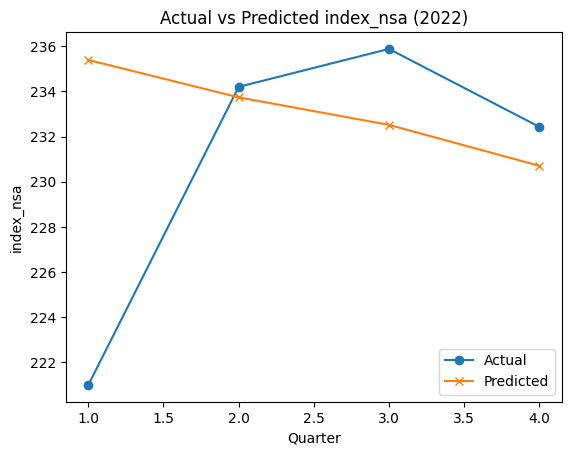

In [40]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt

# Train on 1990–2021, test on 2022
train_df = chicago[chicago['Year'] <= 2021]
test_df = chicago[chicago['Year'] == 2022]

# Define features and target
X_train = train_df.drop(columns=['index_nsa', 'City', 'Year', 'Quarter', 'Unemployment Rate'])
y_train = train_df['index_nsa']
X_test = test_df.drop(columns=['index_nsa', 'City', 'Year', 'Quarter', 'Unemployment Rate'])
y_test = test_df['index_nsa'] if 'index_nsa' in test_df else None  # safeguard

# Train the model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict for 2022
y_pred_2022 = model.predict(X_test)

# Combine predictions with test data
predictions_2022 = test_df.copy()
predictions_2022['Predicted_index_nsa'] = y_pred_2022

# If actual 2022 values exist, compute percent difference and validation metrics
if y_test is not None:
    predictions_2022['Actual_index_nsa'] = y_test.values
    predictions_2022['Percent_Difference'] = (
        abs(predictions_2022['Predicted_index_nsa'] - predictions_2022['Actual_index_nsa'])
        / predictions_2022['Actual_index_nsa'] * 100
    )

    # Compute evaluation metrics
    mae = mean_absolute_error(y_test, y_pred_2022)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred_2022))
    r2 = r2_score(y_test, y_pred_2022)

    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
    print(f"R² Score: {r2:.4f}")
    print("\nDetailed Predictions:\n")
else:
    print("No actual 2022 index_nsa values available for validation.\n")

# Show detailed predictions
print(predictions_2022[['Year', 'Quarter', 'Actual_index_nsa', 'Predicted_index_nsa', 'Percent_Difference']])

# Optional: Plot actual vs predicted for 2022
if y_test is not None:
    plt.plot(predictions_2022['Quarter'], predictions_2022['Actual_index_nsa'], label='Actual', marker='o')
    plt.plot(predictions_2022['Quarter'], predictions_2022['Predicted_index_nsa'], label='Predicted', marker='x')
    plt.xlabel('Quarter')
    plt.ylabel('index_nsa')
    plt.title('Actual vs Predicted index_nsa (2022)')
    plt.legend()
    plt.show()


Optimal Ridge alpha: 0.9326

=== Validation on 2022 ===

Linear Regression Performance:
  MAE  = 4.3338
  RMSE = 5.6104
  R²   = 0.0745

Ridge Regression Performance:
  MAE  = 4.3907
  RMSE = 5.6393
  R²   = 0.0649


Detailed Linear Regression Predictions (2022):
     Year  Quarter  Actual_index_nsa  Linear_Pred  Percent_Diff_Linear
128  2022        1            221.00   218.750316             1.017956
129  2022        2            234.20   224.282504             4.234627
130  2022        3            235.88   235.433357             0.189352
131  2022        4            232.43   237.151290             2.031274


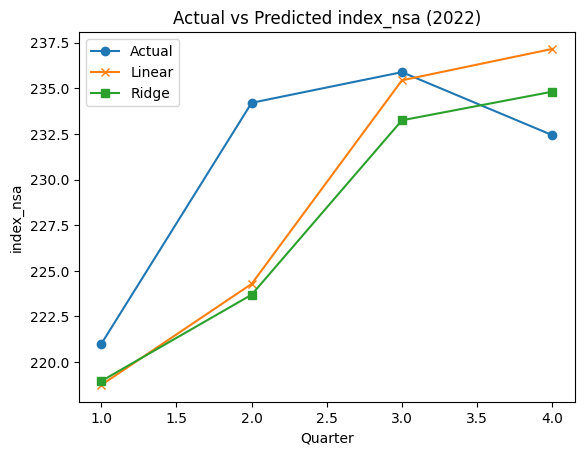


Summary of Model Performance (2022):
               Model       MAE      RMSE        R2
0  Linear Regression  4.333778  5.610434  0.074474
1   Ridge Regression  4.390700  5.639251  0.064942


In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, RidgeCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# =====================================================
# 1. Prepare Data
# =====================================================
df = chicago.copy().sort_values(['Year', 'Quarter']).reset_index(drop=True)

# Create lag feature: previous quarter's index_nsa
df['Lag1_index'] = df['index_nsa'].shift(1)

# Drop the first row (NaN lag)
df = df.dropna(subset=['Lag1_index'])

# Restrict training to recent years
train_df = df[df['Year'].between(2010, 2021)]
test_df = df[df['Year'] == 2022]

# Define features (drop identifiers and target)
drop_cols = ['index_nsa', 'City', 'Year', 'Quarter', 'Unemployment Rate']
features = [col for col in train_df.columns if col not in drop_cols]

X_train = train_df[features]
y_train = train_df['index_nsa']
X_test = test_df[features]
y_test = test_df['index_nsa']

# =====================================================
# 2. Standardize Numeric Features
# =====================================================
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# =====================================================
# 3. Train Models
# =====================================================

# Linear Regression
lin_model = LinearRegression()
lin_model.fit(X_train_scaled, y_train)
lin_pred = lin_model.predict(X_test_scaled)

# Ridge Regression (auto alpha)
ridge = RidgeCV(alphas=np.logspace(-3, 3, 100), cv=5)
ridge.fit(X_train_scaled, y_train)
ridge_pred = ridge.predict(X_test_scaled)
print(f"Optimal Ridge alpha: {ridge.alpha_:.4f}")

# =====================================================
# 4. Evaluate Models
# =====================================================
def evaluate_model(name, y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    print(f"{name} Performance:")
    print(f"  MAE  = {mae:.4f}")
    print(f"  RMSE = {rmse:.4f}")
    print(f"  R²   = {r2:.4f}\n")
    return {"Model": name, "MAE": mae, "RMSE": rmse, "R2": r2}

print("\n=== Validation on 2022 ===\n")
results = []
results.append(evaluate_model("Linear Regression", y_test, lin_pred))
results.append(evaluate_model("Ridge Regression", y_test, ridge_pred))

# Combine predictions
comparison = test_df.copy()
comparison['Actual_index_nsa'] = y_test.values
comparison['Linear_Pred'] = lin_pred
comparison['Ridge_Pred'] = ridge_pred
comparison['Percent_Diff_Linear'] = (
    abs(comparison['Linear_Pred'] - comparison['Actual_index_nsa'])
    / comparison['Actual_index_nsa'] * 100
)

print("\nDetailed Linear Regression Predictions (2022):")
print(comparison[['Year', 'Quarter', 'Actual_index_nsa', 'Linear_Pred', 'Percent_Diff_Linear']])

# =====================================================
# 5. Plot Actual vs Predictions
# =====================================================
plt.plot(comparison['Quarter'], comparison['Actual_index_nsa'], label='Actual', marker='o')
plt.plot(comparison['Quarter'], comparison['Linear_Pred'], label='Linear', marker='x')
plt.plot(comparison['Quarter'], comparison['Ridge_Pred'], label='Ridge', marker='s')
plt.xlabel('Quarter')
plt.ylabel('index_nsa')
plt.title('Actual vs Predicted index_nsa (2022)')
plt.legend()
plt.show()

# =====================================================
# 6. Summary Table
# =====================================================
print("\nSummary of Model Performance (2022):")
perf_df = pd.DataFrame(results)
print(perf_df)


Optimal Ridge alpha: 0.1748

=== Validation on 2022 ===

Linear Regression Performance:
  MAE  = 7.6748
  RMSE = 8.1302
  R²   = 0.0377

Ridge Regression Performance:
  MAE  = 6.8988
  RMSE = 7.3410
  R²   = 0.2155


Detailed Linear Regression Predictions (2022):
     Year  Quarter  Actual_index_nsa  Linear_Pred  Percent_Diff_Linear
128  2022        1            340.14   344.008831             1.137423
129  2022        2            357.90   349.927622             2.227543
130  2022        3            360.75   368.171754             2.057312
131  2022        4            358.74   370.176329             3.187916


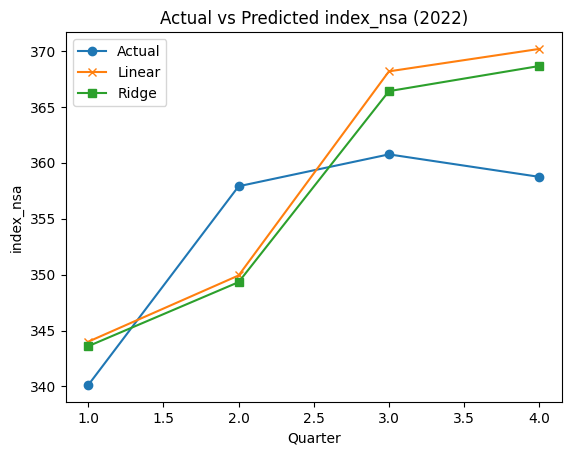


Summary of Model Performance (2022):
               Model       MAE      RMSE        R2
0  Linear Regression  7.674823  8.130171  0.037691
1   Ridge Regression  6.898834  7.340957  0.215450


In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, RidgeCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# =====================================================
# 1. Prepare Data
# =====================================================
df = ny.copy().sort_values(['Year', 'Quarter']).reset_index(drop=True)

# Create lag feature: previous quarter's index_nsa
df['Lag1_index'] = df['index_nsa'].shift(1)

# Drop the first row (NaN lag)
df = df.dropna(subset=['Lag1_index'])

# Restrict training to recent years
train_df = df[df['Year'].between(2010, 2021)]
test_df = df[df['Year'] == 2022]

# Define features (drop identifiers and target)
drop_cols = ['index_nsa', 'City', 'Year', 'Quarter', 'Unemployment Rate']
features = [col for col in train_df.columns if col not in drop_cols]

X_train = train_df[features]
y_train = train_df['index_nsa']
X_test = test_df[features]
y_test = test_df['index_nsa']

# =====================================================
# 2. Standardize Numeric Features
# =====================================================
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# =====================================================
# 3. Train Models
# =====================================================

# Linear Regression
lin_model = LinearRegression()
lin_model.fit(X_train_scaled, y_train)
lin_pred = lin_model.predict(X_test_scaled)

# Ridge Regression (auto alpha)
ridge = RidgeCV(alphas=np.logspace(-3, 3, 100), cv=5)
ridge.fit(X_train_scaled, y_train)
ridge_pred = ridge.predict(X_test_scaled)
print(f"Optimal Ridge alpha: {ridge.alpha_:.4f}")

# =====================================================
# 4. Evaluate Models
# =====================================================
def evaluate_model(name, y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    print(f"{name} Performance:")
    print(f"  MAE  = {mae:.4f}")
    print(f"  RMSE = {rmse:.4f}")
    print(f"  R²   = {r2:.4f}\n")
    return {"Model": name, "MAE": mae, "RMSE": rmse, "R2": r2}

print("\n=== Validation on 2022 ===\n")
results = []
results.append(evaluate_model("Linear Regression", y_test, lin_pred))
results.append(evaluate_model("Ridge Regression", y_test, ridge_pred))

# Combine predictions
comparison = test_df.copy()
comparison['Actual_index_nsa'] = y_test.values
comparison['Linear_Pred'] = lin_pred
comparison['Ridge_Pred'] = ridge_pred
comparison['Percent_Diff_Linear'] = (
    abs(comparison['Linear_Pred'] - comparison['Actual_index_nsa'])
    / comparison['Actual_index_nsa'] * 100
)

print("\nDetailed Linear Regression Predictions (2022):")
print(comparison[['Year', 'Quarter', 'Actual_index_nsa', 'Linear_Pred', 'Percent_Diff_Linear']])

# =====================================================
# 5. Plot Actual vs Predictions
# =====================================================
plt.plot(comparison['Quarter'], comparison['Actual_index_nsa'], label='Actual', marker='o')
plt.plot(comparison['Quarter'], comparison['Linear_Pred'], label='Linear', marker='x')
plt.plot(comparison['Quarter'], comparison['Ridge_Pred'], label='Ridge', marker='s')
plt.xlabel('Quarter')
plt.ylabel('index_nsa')
plt.title('Actual vs Predicted index_nsa (2022)')
plt.legend()
plt.show()

# =====================================================
# 6. Summary Table
# =====================================================
print("\nSummary of Model Performance (2022):")
perf_df = pd.DataFrame(results)
print(perf_df)


Optimal Ridge alpha: 0.0010

=== Validation on 2022 ===

Linear Regression Performance:
  MAE  = 24.3220
  RMSE = 31.2580
  R²   = -2.2877

Ridge Regression Performance:
  MAE  = 24.3007
  RMSE = 31.2291
  R²   = -2.2816


Detailed Linear Regression Predictions (2022):
     Year  Quarter  Actual_index_nsa  Linear_Pred  Percent_Diff_Linear
128  2022        1            457.57   468.680721             2.428201
129  2022        2            495.27   490.113644             1.041120
130  2022        3            502.20   527.283214             4.994666
131  2022        4            478.18   534.117864            11.698077


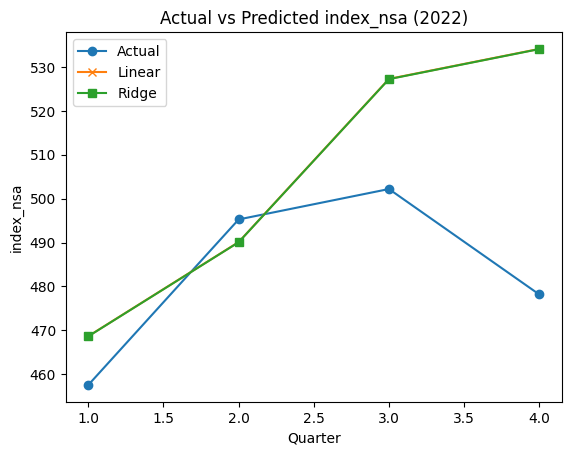


Summary of Model Performance (2022):
               Model        MAE       RMSE        R2
0  Linear Regression  24.322039  31.257992 -2.287729
1   Ridge Regression  24.300714  31.229054 -2.281644


In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, RidgeCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# =====================================================
# 1. Prepare Data
# =====================================================
df = phoenix.copy().sort_values(['Year', 'Quarter']).reset_index(drop=True)

# Create lag feature: previous quarter's index_nsa
df['Lag1_index'] = df['index_nsa'].shift(1)

# Drop the first row (NaN lag)
df = df.dropna(subset=['Lag1_index'])

# Restrict training to recent years
train_df = df[df['Year'].between(2010, 2021)]
test_df = df[df['Year'] == 2022]

# Define features (drop identifiers and target)
drop_cols = ['index_nsa', 'City', 'Year', 'Quarter', 'Unemployment Rate']
features = [col for col in train_df.columns if col not in drop_cols]

X_train = train_df[features]
y_train = train_df['index_nsa']
X_test = test_df[features]
y_test = test_df['index_nsa']

# =====================================================
# 2. Standardize Numeric Features
# =====================================================
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# =====================================================
# 3. Train Models
# =====================================================

# Linear Regression
lin_model = LinearRegression()
lin_model.fit(X_train_scaled, y_train)
lin_pred = lin_model.predict(X_test_scaled)

# Ridge Regression (auto alpha)
ridge = RidgeCV(alphas=np.logspace(-3, 3, 100), cv=5)
ridge.fit(X_train_scaled, y_train)
ridge_pred = ridge.predict(X_test_scaled)
print(f"Optimal Ridge alpha: {ridge.alpha_:.4f}")

# =====================================================
# 4. Evaluate Models
# =====================================================
def evaluate_model(name, y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    print(f"{name} Performance:")
    print(f"  MAE  = {mae:.4f}")
    print(f"  RMSE = {rmse:.4f}")
    print(f"  R²   = {r2:.4f}\n")
    return {"Model": name, "MAE": mae, "RMSE": rmse, "R2": r2}

print("\n=== Validation on 2022 ===\n")
results = []
results.append(evaluate_model("Linear Regression", y_test, lin_pred))
results.append(evaluate_model("Ridge Regression", y_test, ridge_pred))

# Combine predictions
comparison = test_df.copy()
comparison['Actual_index_nsa'] = y_test.values
comparison['Linear_Pred'] = lin_pred
comparison['Ridge_Pred'] = ridge_pred
comparison['Percent_Diff_Linear'] = (
    abs(comparison['Linear_Pred'] - comparison['Actual_index_nsa'])
    / comparison['Actual_index_nsa'] * 100
)

print("\nDetailed Linear Regression Predictions (2022):")
print(comparison[['Year', 'Quarter', 'Actual_index_nsa', 'Linear_Pred', 'Percent_Diff_Linear']])

# =====================================================
# 5. Plot Actual vs Predictions
# =====================================================
plt.plot(comparison['Quarter'], comparison['Actual_index_nsa'], label='Actual', marker='o')
plt.plot(comparison['Quarter'], comparison['Linear_Pred'], label='Linear', marker='x')
plt.plot(comparison['Quarter'], comparison['Ridge_Pred'], label='Ridge', marker='s')
plt.xlabel('Quarter')
plt.ylabel('index_nsa')
plt.title('Actual vs Predicted index_nsa (2022)')
plt.legend()
plt.show()

# =====================================================
# 6. Summary Table
# =====================================================
print("\nSummary of Model Performance (2022):")
perf_df = pd.DataFrame(results)
print(perf_df)


Optimal Ridge alpha: 0.0163

=== Validation on 2022 ===

Linear Regression Performance:
  MAE  = 17.6965
  RMSE = 21.6697
  R²   = -2.2704

Ridge Regression Performance:
  MAE  = 17.3352
  RMSE = 21.1409
  R²   = -2.1127


Detailed Linear Regression Predictions (2022):
     Year  Quarter  Actual_index_nsa  Linear_Pred  Percent_Diff_Linear
128  2022        1            477.82   481.995223             0.873807
129  2022        2            507.87   501.114237             1.330215
130  2022        3            506.38   532.849208             5.227143
131  2022        4            496.39   529.775792             6.725718


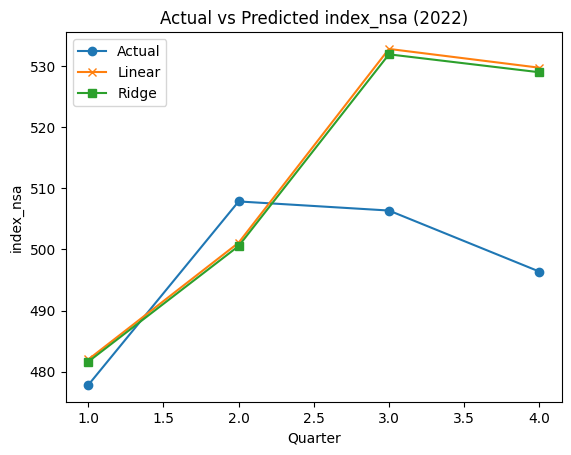


Summary of Model Performance (2022):
               Model        MAE       RMSE        R2
0  Linear Regression  17.696496  21.669696 -2.270408
1   Ridge Regression  17.335180  21.140893 -2.112741


In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, RidgeCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# =====================================================
# 1. Prepare Data
# =====================================================
df = la.copy().sort_values(['Year', 'Quarter']).reset_index(drop=True)

# Create lag feature: previous quarter's index_nsa
df['Lag1_index'] = df['index_nsa'].shift(1)

# Drop the first row (NaN lag)
df = df.dropna(subset=['Lag1_index'])

# Restrict training to recent years
train_df = df[df['Year'].between(2010, 2021)]
test_df = df[df['Year'] == 2022]

# Define features (drop identifiers and target)
drop_cols = ['index_nsa', 'City', 'Year', 'Quarter', 'Unemployment Rate']
features = [col for col in train_df.columns if col not in drop_cols]

X_train = train_df[features]
y_train = train_df['index_nsa']
X_test = test_df[features]
y_test = test_df['index_nsa']

# =====================================================
# 2. Standardize Numeric Features
# =====================================================
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# =====================================================
# 3. Train Models
# =====================================================

# Linear Regression
lin_model = LinearRegression()
lin_model.fit(X_train_scaled, y_train)
lin_pred = lin_model.predict(X_test_scaled)

# Ridge Regression (auto alpha)
ridge = RidgeCV(alphas=np.logspace(-3, 3, 100), cv=5)
ridge.fit(X_train_scaled, y_train)
ridge_pred = ridge.predict(X_test_scaled)
print(f"Optimal Ridge alpha: {ridge.alpha_:.4f}")

# =====================================================
# 4. Evaluate Models
# =====================================================
def evaluate_model(name, y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    print(f"{name} Performance:")
    print(f"  MAE  = {mae:.4f}")
    print(f"  RMSE = {rmse:.4f}")
    print(f"  R²   = {r2:.4f}\n")
    return {"Model": name, "MAE": mae, "RMSE": rmse, "R2": r2}

print("\n=== Validation on 2022 ===\n")
results = []
results.append(evaluate_model("Linear Regression", y_test, lin_pred))
results.append(evaluate_model("Ridge Regression", y_test, ridge_pred))

# Combine predictions
comparison = test_df.copy()
comparison['Actual_index_nsa'] = y_test.values
comparison['Linear_Pred'] = lin_pred
comparison['Ridge_Pred'] = ridge_pred
comparison['Percent_Diff_Linear'] = (
    abs(comparison['Linear_Pred'] - comparison['Actual_index_nsa'])
    / comparison['Actual_index_nsa'] * 100
)

print("\nDetailed Linear Regression Predictions (2022):")
print(comparison[['Year', 'Quarter', 'Actual_index_nsa', 'Linear_Pred', 'Percent_Diff_Linear']])

# =====================================================
# 5. Plot Actual vs Predictions
# =====================================================
plt.plot(comparison['Quarter'], comparison['Actual_index_nsa'], label='Actual', marker='o')
plt.plot(comparison['Quarter'], comparison['Linear_Pred'], label='Linear', marker='x')
plt.plot(comparison['Quarter'], comparison['Ridge_Pred'], label='Ridge', marker='s')
plt.xlabel('Quarter')
plt.ylabel('index_nsa')
plt.title('Actual vs Predicted index_nsa (2022)')
plt.legend()
plt.show()

# =====================================================
# 6. Summary Table
# =====================================================
print("\nSummary of Model Performance (2022):")
perf_df = pd.DataFrame(results)
print(perf_df)


Optimal Ridge alpha: 0.2310

=== Validation on 2022 ===

Linear Regression Performance:
  MAE  = 6.0302
  RMSE = 8.3734
  R²   = 0.3817

Ridge Regression Performance:
  MAE  = 3.6511
  RMSE = 5.7164
  R²   = 0.7118


Detailed Linear Regression Predictions (2022):
     Year  Quarter  Actual_index_nsa  Linear_Pred  Percent_Diff_Linear
128  2022        1            351.52   352.677102             0.329171
129  2022        2            365.17   367.670420             0.684728
130  2022        3            377.04   381.637347             1.219326
131  2022        4            377.61   393.476021             4.201695


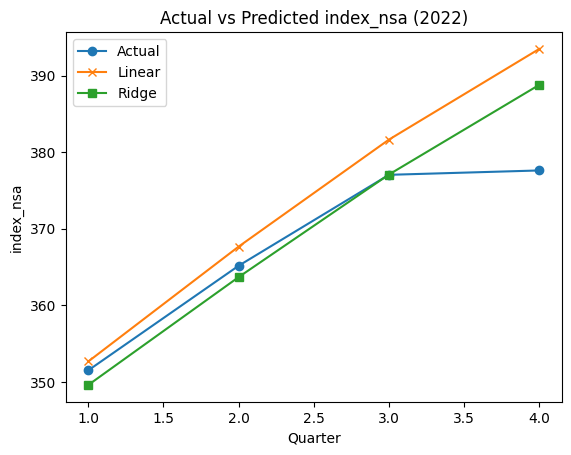


Summary of Model Performance (2022):
               Model       MAE      RMSE        R2
0  Linear Regression  6.030222  8.373428  0.381659
1   Ridge Regression  3.651109  5.716358  0.711822


In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, RidgeCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# =====================================================
# 1. Prepare Data
# =====================================================
df = houston.copy().sort_values(['Year', 'Quarter']).reset_index(drop=True)

# Create lag feature: previous quarter's index_nsa
df['Lag1_index'] = df['index_nsa'].shift(1)

# Drop the first row (NaN lag)
df = df.dropna(subset=['Lag1_index'])

# Restrict training to recent years
train_df = df[df['Year'].between(2010, 2021)]
test_df = df[df['Year'] == 2022]

# Define features (drop identifiers and target)
drop_cols = ['index_nsa', 'City', 'Year', 'Quarter', 'Unemployment Rate']
features = [col for col in train_df.columns if col not in drop_cols]

X_train = train_df[features]
y_train = train_df['index_nsa']
X_test = test_df[features]
y_test = test_df['index_nsa']

# =====================================================
# 2. Standardize Numeric Features
# =====================================================
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# =====================================================
# 3. Train Models
# =====================================================

# Linear Regression
lin_model = LinearRegression()
lin_model.fit(X_train_scaled, y_train)
lin_pred = lin_model.predict(X_test_scaled)

# Ridge Regression (auto alpha)
ridge = RidgeCV(alphas=np.logspace(-3, 3, 100), cv=5)
ridge.fit(X_train_scaled, y_train)
ridge_pred = ridge.predict(X_test_scaled)
print(f"Optimal Ridge alpha: {ridge.alpha_:.4f}")

# =====================================================
# 4. Evaluate Models
# =====================================================
def evaluate_model(name, y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    print(f"{name} Performance:")
    print(f"  MAE  = {mae:.4f}")
    print(f"  RMSE = {rmse:.4f}")
    print(f"  R²   = {r2:.4f}\n")
    return {"Model": name, "MAE": mae, "RMSE": rmse, "R2": r2}

print("\n=== Validation on 2022 ===\n")
results = []
results.append(evaluate_model("Linear Regression", y_test, lin_pred))
results.append(evaluate_model("Ridge Regression", y_test, ridge_pred))

# Combine predictions
comparison = test_df.copy()
comparison['Actual_index_nsa'] = y_test.values
comparison['Linear_Pred'] = lin_pred
comparison['Ridge_Pred'] = ridge_pred
comparison['Percent_Diff_Linear'] = (
    abs(comparison['Linear_Pred'] - comparison['Actual_index_nsa'])
    / comparison['Actual_index_nsa'] * 100
)

print("\nDetailed Linear Regression Predictions (2022):")
print(comparison[['Year', 'Quarter', 'Actual_index_nsa', 'Linear_Pred', 'Percent_Diff_Linear']])

# =====================================================
# 5. Plot Actual vs Predictions
# =====================================================
plt.plot(comparison['Quarter'], comparison['Actual_index_nsa'], label='Actual', marker='o')
plt.plot(comparison['Quarter'], comparison['Linear_Pred'], label='Linear', marker='x')
plt.plot(comparison['Quarter'], comparison['Ridge_Pred'], label='Ridge', marker='s')
plt.xlabel('Quarter')
plt.ylabel('index_nsa')
plt.title('Actual vs Predicted index_nsa (2022)')
plt.legend()
plt.show()

# =====================================================
# 6. Summary Table
# =====================================================
print("\nSummary of Model Performance (2022):")
perf_df = pd.DataFrame(results)
print(perf_df)
